# The Expectation-Maximization Algorithm

In [1]:
# Common imports
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 
import pickle # we have to import a pickle file
import os 

# maximum number of columns
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], s=2)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.title('Artificial dataset created with make_blobs')

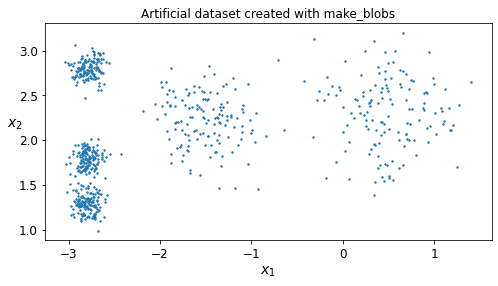

In [22]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

blob_centers = np.array(
    [[ 0.5,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

# standard deviation of the blobs
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

# make a feature matrix (X) and the labels (y)
X, y = make_blobs(n_samples=700, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

# centers = [[1, 1], [-1, -1], [1, -1], [-1,1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
# Scale and standardize the dataset
# X = StandardScaler().fit_transform(X)
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [23]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 5, n_init = 10)
gm.fit(X)

print(gm.weights_)
print()
print(gm.means_)
print()
print(gm.covariances_)

[0.19945854 0.20162245 0.19772791 0.19998091 0.2012102 ]

[[-2.79176515  1.79155566]
 [ 0.47453787  2.30305601]
 [-1.51406695  2.21880732]
 [-2.78620413  2.79912702]
 [-2.79852448  1.29259591]]

[[[ 0.0077195   0.0007523 ]
  [ 0.0007523   0.00969727]]

 [[ 0.15136812 -0.0078347 ]
  [-0.0078347   0.14790242]]

 [[ 0.08739468 -0.01108655]
  [-0.01108655  0.08131186]]

 [[ 0.00956819  0.00104863]
  [ 0.00104863  0.00984551]]

 [[ 0.00812158 -0.00083944]
  [-0.00083944  0.01115809]]]


**Aim:** Understand the algorithm, which assigns the unknown parameters $\mu_j, \Sigma_j$ and $q_j$ as well as clusters $j$.

# The Log-Likelihood Function

![](plots/likelihood_explained.png)

### The likelihood function:

$$ \mathcal{L} = \mathcal{L}(\vec{\theta}) = \mathcal{L}(\vec{\theta}| \vec{x}) $$

The likelihood function $\mathcal{L}$ describes how plausible a particular set of parameter values $\vec{θ}$ are, after the outcome $\vec{x}$ is known.

### Upper left plot:
Consider a one-dimensional mixture model of two Gaussian distributions centered at –4 and +1.For simplicity, this toy model has a single parameter θ that controls the standard deviations
of both distributions. The top-left **contour plot** shows the entire
model $f(x; \theta) = \mathcal{L}(\theta| x)$  as a function of both $x$ and $\theta$. 

### Lower left plot (probability distribution):
To estimate the probability distribution (PDF) of
a future outcome $x$, you need to set the model parameter $\theta$. (This can be done via **maximum likelihood estimation (MLE)**: $\text{argmax}_{\theta} f(x; \theta)$. In linear regression the maximum likelihood estimation for $\vec{\omega}$ is the one, that minimizes the residual sum of squares.) 

For example, if you set $\theta$ to 1.3 (the horizontal black line in the upper left plot), you get the probability density function $f(x; \theta=1.3)$ shown
in the lower-left plot. Say you want to estimate the probability that $x$ will fall between
–2 and +2. You must calculate the integral of the PDF on this range (i.e., the area of
the shaded region). 

### Upper right plot

But what if you don’t know $\theta$, and instead if you have observed a
single instance x=2.5 (the vertical blue line in the upper-left plot)? In this case, you get the
likelihood function $\mathcal{L}(\theta|x=2.5)=f(x=2.5; \theta)$, represented in the upper-right plot.

In short, the PDF is a function of $x$ (with $\theta$ fixed), while the likelihood function is a
function of $\theta$ (with $x$ fixed). It is important to understand that the likelihood function
is not a probability distribution: if you integrate a probability distribution over all
possible values of $x$, you always get 1; but if you integrate the likelihood function over
all possible values of $\theta$, the result can be any positive value.

Given a dataset $X$, a common task is to try to estimate the most likely values for the
model parameters. To do this, you must find the values that maximize the likelihood
function, given $X$. In this example, if you have observed a single instance $x=2.5$, the
maximum likelihood estimate (MLE) of $\theta$ is $\theta=1.5$. 

If a **prior probability distribution** $g$
over $\theta$ exists, it is possible to take it into account by maximizing $\mathcal{L}(\theta|x) g(\theta)$ rather
than just maximizing $\mathcal{L}(\theta|x)$. This is called **maximum a-posteriori (MAP) estimation**.Since MAP constrains the parameter values, you can think of it as a regularized version of MLE.

### Lower right plot:

Notice that maximizing the likelihood function is equivalent to maximizing its logarithm
Indeed the logarithm
is a strictly increasing function, so if $\theta$ maximizes the log likelihood, it also maximizes
the likelihood. **It turns out that it is generally easier to maximize the log likelihood.**
For example, if you observed several independent instances $x(1)$ to $x(m)$, you would
need to find the value of $\theta$ that maximizes the product of the individual likelihood
functions. But it is equivalent, and much simpler, to maximize the sum (not the product)
of the log likelihood functions, thanks to the magic of the logarithm which converts
products into sums: $log(ab)=log(a)+log(b)$.

# Example of maximum log-likelihood: Binary outcome

$$ \mathcal{L}(\theta) = \theta^{n_1} \cdot \left[ 1 - \theta \right]^{n_2}  $$

Calculate $$\frac{\partial}{\partial \theta} \text{log} \mathcal{l}(\theta)$$

# Example of maximum log-likelihood: Linear Regression and RSS/MSE

One-dimensional:
$$p(y|x;\mu, \sigma) = \mathcal{N}(y|\mu(x), \sigma) \; , \text{with} \, \mu(x) = \omega_0 + \omega_1 \cdot x$$

Calculate $$\frac{\partial}{\partial \theta} \text{log} \mathcal{l}(\theta)$$
gives $$ \hat{\omega} = \left(X^{T} X\right)^{-1} X^{T} y  $$

# Gaussian Mixture Models

In this model, each base distribution in the mixture is a multivariate
Gaussian with mean $\mu_k$ and covariance matrix $\Sigma_k$. Thus the model has the form
$$p(x_i|\theta) = \sum_{k = 1}^{K} q_k  \mathcal{N}(x_i|μ_k,\Sigma_k)$$

### Using a Mixture Model for Clustering

We first fit the mixture
model, and then compute $p(z_i = k|x_i,\theta)$, which represents the posterior probability that point
$i$ belongs to cluster $k$. This is known as the **responsibility** of cluster k for point i, $r_{ik}$ and can be
computed using Bayes rule.

## Parameter Estimation in Mixture Models

One approach to compute the MLE or MAP is to use a generic **gradient-based optimizer** to find a minimum of the
negative log likelihood or NLL.

However, we often have to enforce constraints, such as the fact that covariance matrices must be
positive definite, mixing weights must sum to one, etc., which can be tricky. If we have missing data and/or latent (hidden) variables, then computing of the MLE/MAP becomes hard. 

In
such cases, it is often much simpler (but not always faster) to use an algorithm called **expectation maximization**, or **EM** for short. This is a simple iterative algorithm, often with closed-form updates at each step. Furthermore, the algorithm automatically enforce the required constraints.

### Similarity to K-Means Algorithm:

It has many similarities with the K-Means algorithm:
it also initializes the cluster parameters randomly, then it repeats two steps
until convergence, first assigning instances to clusters (this is called the **expectation
step**) and then updating the clusters (this is called the **maximization step**). 

In the context of clustering, you can think of EM as a generalization of
K-Means that not only finds the cluster centers ($\mu(1) to \mu(k)$), but also their size, shape,
and orientation ($\Sigma(1) to \Sigma(k)$), as well as their relative weights ($q(1) to q(k)$). 

Unlike KMeans,
though, EM uses soft cluster assignments, not hard assignments. For each
instance, during the expectation step, the algorithm estimates the probability that it
belongs to each cluster (based on the current cluster parameters). Then, during the
maximization step, each cluster is updated using all the instances in the dataset, with
each instance weighted by the estimated probability that it belongs to that cluster.
These probabilities are called the responsibilities of the clusters for the instances.

![](./plots/E_M_plot.png)

## Basic Idea

Let $x_i$ be the observed variables in case i, and let $z_i$ be the hidden 
variables. The goal is to maximize the log likelihood of the observed data:
$$p(\theta) =
\sum_{i=1} \text{log} p(x_i|\theta) =
\sum_{i=1} \text{log} \sum_{z_i} p(x_i, z_i|\theta) $$

Unfortunately this is hard to optimize, since the log cannot be pushed inside the sum.

EM gets around this problem as follows. Define the complete data log likelihood to be
$$l_c(\theta) =
\sum_{i=1} \text{log} p(x_i, z_i|\theta)$$
This cannot be computed, since $z_i$ is unknown. So let us define the expected complete data
log likelihood as follows:
$$Q(\theta, \theta^{t−1}) = \mathbb{E} \left[l_c(\theta) | D, \theta^{t−1} \right]$$ 
where $t$ is the current iteration number. $Q$ is called the auxiliary function. The expectation
is taken wrt the old parameters, $\theta_t−1$, and the observed data $\mathcal{D}$. The goal of the E step is to
compute $Q(\theta, \theta_t−1)$, or rather, the terms inside of it which the MLE depends on; these are
known as the expected sufficient statistics or ESS. 

In the M step, we optimize the Q function
w.r.t. $\theta$: $$\theta^t = argmax_{\theta} Q(\theta, \theta^{t−1})$$

## EM for Gaussian Mixture Models

The formulas can be found at: https://github.com/iubh/DLMDSML01/blob/main/Q_A_Sessions/02_clustering/EM_algorithm_explanation.pdf